In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path

import ccxt
import matplotlib.pyplot as plt

import sys
sys.path.append("..") 
from tp_config import *
from portfolio_tools import load_data_for_portfolio, calc_frontier, calc_weights
from tp_utils.data_provider import read_prices, read_data, load_data_from_exchange

In [2]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns, objective_functions

### Load Data

In [3]:
data_path = DATA_PATH_CRYPTO

pair = 'USDT'

index_assets = pd.read_csv('index_assets.csv')['asset'].tolist()
index_low_assets = pd.read_csv('index_low_assets.csv')['asset'].tolist()

assets = index_assets + index_low_assets
markets = [m + '-' + pair for m in assets]

In [ ]:
exchange = ccxt.bybit()
start_timestamp = exchange.parse8601('2023-04-01 00:00:00')
timeframes = {'4h':240}

data_path = DATA_PATH_CRYPTO + '/' + pair
load_data_from_exchange(exchange, markets, timeframes, start_timestamp, data_path, 10, verbose = False)

In [476]:
df_all =  load_data_for_portfolio(markets, '1h')   
print(datetime.fromtimestamp(df_all.index[0]/1000))
print(datetime.fromtimestamp(df_all.index[-1]/1000))

AVAX-USDT
BCH-USDT
BTC-USDT
BNB-USDT
DOT-USDT
DOGE-USDT
ETH-USDT
LINK-USDT
LTC-USDT
LUNA-USDT
MATIC-USDT
MNT-USDT
SOL-USDT
TON-USDT
TRX-USDT
AAVE-USDT
ADA-USDT
AEVO-USDT
ALGO-USDT
APT-USDT
AXS-USDT
BONK-USDT
BOME-USDT
CAKE-USDT
CYBER-USDT
CPOOL-USDT
EOS-USDT
ETC-USDT
ETHFI-USDT
FIRE-USDT
FLT-USDT
FTT-USDT
FTM-USDT
GALA-USDT
INJ-USDT
ICP-USDT
JUP-USDT
NEON-USDT
NEAR-USDT
ONDO-USDT
PEPE-USDT
PENDLE-USDT
PPT-USDT
PYTH-USDT
RUNE-USDT
SEI-USDT
SQT-USDT
SUI-USDT
THETA-USDT
TOKEN-USDT
UNI-USDT
WAVES-USDT
WLD-USDT
XRP-USDT
ZIL-USDT
2023-04-01 04:00:00
2024-03-29 21:00:00


In [5]:
def load_pybroker(assets, tf):
    res = []
    for asset in assets:
        market = asset + '-' + pair
        x = read_data(market, tf)
        x.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
        x['symbol'] = asset
        x.date = pd.to_datetime(x["date"], unit='ms')
        res.append(x)
    df = pd.concat(res)
    df = df.reset_index(drop = True)
    return df

In [552]:
tf = '4h'
assets = ['SOL', 'AVAX', 'BTC', 'BNB','FTT', 'FTM', 'NEAR', 'NEON', 'SUI', 'SEI', 
          'DOGE',  'ETH', 'TON', 'TRX', 'MNT', 'WLD', 'PYTH', 'ADA']
df_prices = load_pybroker(assets, tf)

### Rebalancing

In [303]:
import pybroker as pyb
from datetime import datetime
from pybroker import ExecContext, Strategy, StrategyConfig, FeeMode

pyb.enable_data_source_cache('rebalancing')

In [553]:
def periods(dt: datetime, period) -> bool:
    x = pyb.param('count_periods') 
    if x == period:
        pyb.param('count_periods', 0)
        return True
    else: 
        x += 1
        pyb.param('count_periods', x) 
    return False

def start_of_week(dt: datetime) -> bool:
    if dt.weekday() == 0:
        return True
    return False

def set_target_shares(
    ctxs: dict[str, ExecContext],
    targets: dict[str, float]
):
    for symbol, target in targets.items():
        ctx = ctxs[symbol]
        target_shares = ctx.calc_target_shares(target)
        pos = ctx.long_pos()
        if pos is None:
            ctx.buy_shares = target_shares
        elif pos.shares < target_shares:
            ctx.buy_shares = target_shares - pos.shares
        elif pos.shares > target_shares:
            ctx.sell_shares = pos.shares - target_shares 

In [559]:

pyb.param('lookback', 90)  # Use past year of returns.

def to_dfp(ctxs: dict[str, ExecContext], lookback: int):
    prices = {}
    for ctx in ctxs.values():
        prices[ctx.symbol] = ctx.close[-lookback:]
    df = pd.DataFrame(prices)
    return df

def optimization(ctxs: dict[str, ExecContext]):
    lookback = pyb.param('lookback')
    first_ctx = tuple(ctxs.values())[0]
    if periods(first_ctx.dt, 6):
        dfp = to_dfp(ctxs, lookback) 
        ef = calc_frontier(dfp, "ledoit_wolf",  "ema_historical_return", span = 150)
        dfw = calc_weights(ef, 'max_sharpe', 0, verbose = False) 
        targets = dfw.to_dict()["weights"]
        print(targets)
        set_target_shares(ctxs, targets)

In [613]:
import riskfolio as rp

pyb.param('lookback', 90)  # Use past year of returns.
pyb.param('count_periods', 0)
def calculate_returns(ctxs: dict[str, ExecContext], lookback: int):
    prices = {}
    for ctx in ctxs.values():
        prices[ctx.symbol] = ctx.close[-lookback:]
    df = pd.DataFrame(prices)
    return df.pct_change().dropna()

def optimization(ctxs: dict[str, ExecContext]):
    lookback = pyb.param('lookback')
    first_ctx = tuple(ctxs.values())[0]
#    if start_of_week(first_ctx.dt):
    if periods(first_ctx.dt, 6):
        Y = calculate_returns(ctxs, lookback)
        port = rp.Portfolio(returns=Y)
        port.assets_stats(method_mu='hist', method_cov='hist', d=0.94)
        port.card = None 

    # Then we need to set the constraint on the minimum number of effective assets
        port.nea = 10
        w = port.optimization(
            model='Classic',
            rm='CVaR',
            obj='MaxRet',
            rf=0,      # Risk free rate.
            l=0,       # Risk aversion factor.
            hist=True  # Use historical scenarios.
        )
        
        targets = {
            symbol: w.T[symbol].values[0]
            for symbol in ctxs.keys()
        }
        set_target_shares(ctxs, targets)

In [614]:
def buy_with_stop_loss_and_profit(ctx):
    if not ctx.long_pos():
        ctx.buy_shares = ctx.calc_target_shares(1)
#        ctx.stop_trailing_pct = 5
        #ctx.stop_profit_pct = 15
        ctx.stop_loss_pct = 30

In [615]:
fee = FeeMode('order_percent')
config = StrategyConfig(initial_cash = 1_000_000,
                        fee_mode = fee,
                        fee_amount = 0.1,
                        enable_fractional_shares = True,
                        round_fill_price = False)
strategy = Strategy(df_prices, start_date='1/1/2024', end_date='3/27/2024', config = config)
strategy.add_execution(buy_with_stop_loss_and_profit, assets)


In [616]:
strategy.set_after_exec(optimization)
result = strategy.backtest(warmup=pyb.param('lookback'))

Backtesting: 2024-01-01 00:00:00 to 2024-03-27 00:00:00

Test split: 2024-01-01 00:00:00 to 2024-03-27 00:00:00


100% (517 of 517) |######################| Elapsed Time: 0:00:04 Time:  0:00:040000



Finished backtest: 0:00:05


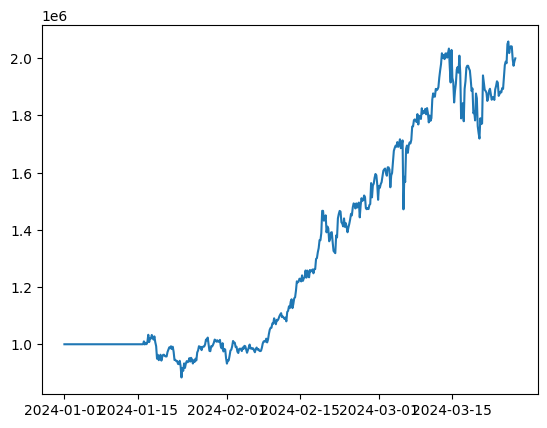

In [617]:
chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index, result.portfolio['market_value'])

In [535]:
pd.set_option('display.min_rows', 100)
pd.set_option('display.max_rows', 100)

In [577]:
result.trades

,type,symbol,entry_date,exit_date,entry,exit,shares,pnl,return_pct,agg_pnl,bars,pnl_per_bar,stop,mae,mfe
id,,,,,,,,,,,,,,,
1,long,SOL,2024-01-16 04:00:00,2024-01-17 04:00:00,96.77,98.71,1.001545635e+04,19480.06,2.01,19480.06,6,3246.68,None,-2.61,4.32
2,long,SEI,2024-01-17 04:00:00,2024-01-17 16:00:00,0.78,0.86,1.366541184e+05,10723.93,10.00,30203.99,3,3574.64,profit,-0.01,0.08
3,long,BTC,2024-01-17 04:00:00,2024-01-18 08:00:00,42771.91,42658.77,7.995553249e-02,-9.05,-0.26,30194.95,7,-1.29,None,-565.27,156.10
4,long,BNB,2024-01-17 04:00:00,2024-01-18 08:00:00,311.74,311.50,8.100572210e+01,-19.43,-0.08,30175.52,7,-2.78,None,-6.02,3.22
5,long,FTT,2024-01-17 04:00:00,2024-01-18 08:00:00,3.04,2.99,2.515189166e+03,-149.40,-1.95,30026.11,7,-21.34,None,-0.14,0.04
6,long,FTM,2024-01-17 04:00:00,2024-01-18 08:00:00,0.41,0.40,4.207633144e+03,-40.33,-2.36,29985.78,7,-5.76,None,-0.02,0.01
7,long,NEON,2024-01-17 04:00:00,2024-01-18 08:00:00,1.61,1.41,1.849826521e-05,-0.00,-12.33,29985.78,7,-0.00,None,-0.24,0.04
8,long,DOGE,2024-01-17 04:00:00,2024-01-18 08:00:00,0.08,0.08,5.563869533e+04,-31.71,-0.70,29954.07,7,-4.53,None,-0.00,0.00
9,long,ETH,2024-01-17 04:00:00,2024-01-18 08:00:00,2563.63,2532.01,3.323159618e+00,-105.08,-1.23,29848.99,7,-15.01,None,-57.38,11.78


In [55]:
result.trades

,type,symbol,entry_date,exit_date,entry,exit,shares,pnl,return_pct,agg_pnl,bars,pnl_per_bar,stop,mae,mfe
id,,,,,,,,,,,,,,,
1,long,ETH,2024-01-22 04:00:00,2024-01-22 20:00:00,2420.89,2327.23,50,-4683.00,-3.87,-4683.00,4,-1170.75,None,-115.87,17.91
2,long,ETH,2024-01-22 04:00:00,2024-01-29 04:00:00,2420.89,2266.12,203,-31418.31,-6.39,-36101.31,42,-748.06,None,-252.68,17.91
3,long,ETH,2024-01-22 08:00:00,2024-01-29 04:00:00,2391.32,2266.12,2,-250.40,-5.24,-36351.71,41,-6.11,None,-223.11,29.60
4,long,ETH,2024-01-22 12:00:00,2024-01-29 04:00:00,2379.18,2266.12,1,-113.06,-4.75,-36464.77,40,-2.83,None,-210.97,25.77
5,long,BTC,2024-01-22 04:00:00,2024-02-12 04:00:00,41003.68,48065.00,4,28245.28,17.22,-8219.49,126,224.17,None,-2451.05,7830.49
6,long,ETH,2024-02-12 04:00:00,2024-02-12 16:00:00,2492.49,2587.31,65,6163.30,3.80,-2056.19,3,2054.43,None,-20.39,94.82
7,long,BTC,2024-01-22 04:00:00,2024-02-19 04:00:00,41003.68,52240.21,5,56182.65,27.40,54126.46,168,334.42,None,-2451.05,11810.31
8,long,BTC,2024-01-22 20:00:00,2024-02-19 04:00:00,39909.35,52240.21,3,36992.58,30.90,91119.04,164,225.56,None,-1356.72,12904.64
9,long,BTC,2024-01-29 04:00:00,2024-02-19 04:00:00,42165.89,52240.21,2,20148.64,23.89,111267.68,126,159.91,None,-369.00,10648.10
